# Benchmark
* sklearn search
* Bayesian Optimaztion
* nevergrad

In [1]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
X, y = datasets.load_diabetes(return_X_y=True)

In [3]:
xgb = XGBRegressor()

In [4]:
scoring='neg_mean_squared_error'
baseline = cross_val_score(xgb, X, y, scoring=scoring, cv=5)
print(baseline.mean())

-3437.074407214106


In [5]:
pipeline = Pipeline([('scaler', StandardScaler()), ('xgb', xgb)])
baseline = cross_val_score(pipeline, X, y, scoring=scoring, cv=5)
print(baseline.mean())

-3435.4432849413233


## Randomized Search

In [6]:
param_dist = {
    'xgb__gamma': range(0, 5),
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': range(1, 50),
    'xgb__min_child_weight': range(1, 10),
    'xgb__n_estimators': range(1, 500),
}

rs = RandomizedSearchCV(pipeline, param_distributions=param_dist, scoring=scoring, cv=5,  n_iter=30)
start = time()
rs.fit(X, y)
print("Randomized Search took %.2f seconds , score = %3.2f" % ((time()-start), rs.score(X, y)))
print(rs.best_params_)

Randomized Search took 47.98 seconds , score = -2426.18
{'xgb__n_estimators': 376, 'xgb__min_child_weight': 4, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.01, 'xgb__gamma': 1}


/home/ubuntu/.conda/envs/machine_learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Grid Search

In [7]:
param_grid = {
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__gamma': [1, 3, 5],
    'xgb__max_depth': [1, 3, 10],
    'xgb__min_child_weight': [1, 5],
    'xgb__n_estimators': [50, 100, 500]
}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=scoring, iid=False)
start = time()
gs.fit(X, y)
print("Grid Search took %.2f seconds , score = %3.2f" % ((time()-start), gs.score(X, y)))
print(gs.best_params_)

Grid Search took 74.47 seconds , score = -2541.31
{'xgb__gamma': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 1, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 100}


In [8]:
print(rs.best_params_)
print(rs.best_score_)
print(gs.best_params_)
print(gs.best_score_)

{'xgb__n_estimators': 376, 'xgb__min_child_weight': 4, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.01, 'xgb__gamma': 1}
-3241.9293023579453
{'xgb__gamma': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 1, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 100}
-3193.2790685275772


## Bayesian Optimization

In [9]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [10]:
bounds = [
    {'name':'learning_rate', 'type':'continuous', 'domain': (0, 0.1)},
    {'name':'gamma', 'type':'continuous', 'domain': (0, 5)},
    {'name':'max_depth', 'type':'discrete', 'domain': (1, 50)},   
    {'name':'n_estimators', 'type':'discrete', 'domain': (1, 1000)},
    {'name':'min_child_weight', 'type':'discrete', 'domain': (1, 10)}
]

# obj function
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBRegressor(
            learning_rate=parameters[0], 
            gamma=parameters[1],
            max_depth=int(parameters[2]), 
            n_estimators=int(parameters[3]), 
            min_child_weight=int(parameters[4])),
        X, y, scoring="neg_mean_squared_error", cv=5).mean()
    score = np.array(score)
    return score

In [11]:
optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bounds, 
                                 model_type='GP', 
                                 acquisition_type='EI',
                                 acquisition_jitter=0.05,
                                 exact_feval=True, 
                                 maximize=True)

start = time()
optimizer.run_optimization(max_iter=30)
print("BO took %.2f seconds" % ((time()-start)))

BO took 65.08 seconds


Baseline neg. MSE = -3435.44
Random search neg. MSE = -3241.93
Grid search neg. MSE = -3193.28
Bayesian optimization neg. MSE = -3218.64


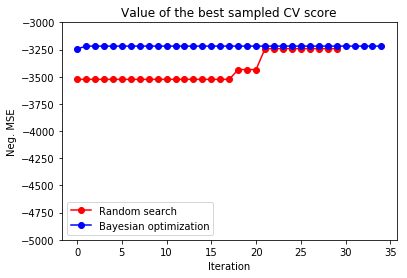

In [12]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(gs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline.mean():.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Grid search neg. MSE = {y_gs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')

plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();


## Nevergrad
### find global maximum in a function.

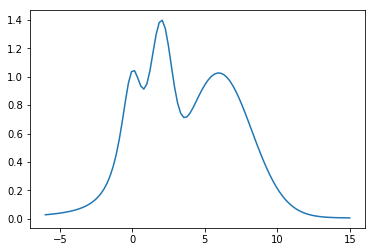

In [13]:
def f(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2 / 10) + 1/(x**2 + 1)

x = np.linspace(-6, 15, 100)
plt.plot(x, f(x))
plt.show()

In [14]:
from nevergrad.optimization import optimizerlib, registry

optimizer = optimizerlib.OnePointDE(instrumentation=1, budget=100, num_workers=4)
g = lambda x: -f(x)[0]

for _ in range(optimizer.budget):
    x = optimizer.ask()
    value = g(*x.args, **x.kwargs)
    optimizer.tell(x, value)

recommendation = optimizer.provide_recommendation()
print(recommendation)

Candidate(args=(array([2.01831647]),), kwargs={})


### Search optimal hyperparameters

In [15]:
from nevergrad import instrumentation as inst

# log distributed between 0.001 and 1
lr = inst.var.Array(1).bounded(0, 3).exponentiated(base=10, coeff=-1)
gamma = inst.var.Array(1).bounded(0, 3)
max_depth = inst.var.OrderedDiscrete(range(1, 50))
n_est = inst.var.OrderedDiscrete(range(1, 1000))
min_childe = inst.var.OrderedDiscrete(range(1, 50))

instrumentation = inst.Instrumentation(lr, gamma, max_depth, n_est, min_childe)

In [16]:
args, kwargs = instrumentation.data_to_arguments([0] * instrumentation.dimension)
print(args, kwargs)

(array([0.03162278]), array([1.5]), 25, 500, 25) {}


In [17]:
def cv_score2(*args):
    lr, gamma, max_depth, n_est, min_child = args
    score = cross_val_score(
        XGBRegressor(
            learning_rate=lr[0], 
            gamma=gamma[0],
            max_depth=int(max_depth), 
            n_estimators=int(n_est), 
            min_child_weight=int(min_child)),
        X, y, scoring=scoring, cv=5).mean()
    #score = np.array(score)
    #print(args, -score)
    return -score

In [18]:
budget = 30
names = ["RandomSearch", "TwoPointsDE", "FastGADiscreteOnePlusOne", "PSO"]

for name in names:
    print(name)
    start = time()
    optimizer = optimizerlib.registry[name](instrumentation, budget=budget, num_workers=10)
    for _ in range(optimizer.budget // 3):
        x1 = optimizer.ask()
        x2 = optimizer.ask()
        x3 = optimizer.ask()
        y1 = cv_score2(*x1.args)
        y2 = cv_score2(*x2.args)
        y3 = cv_score2(*x3.args)
        optimizer.tell(x1, y1)
        optimizer.tell(x2, y2)
        optimizer.tell(x3, y3)
    
    recommendation = optimizer.provide_recommendation()
    print("time %.2f sec" % ((time()-start)))        
    print("name", name, "arg", recommendation.args, "score=", cv_score2(*recommendation.args))

RandomSearch
time 52.64 sec
(array([0.00406691]), array([1.67252583]), 37, 789, 25) 3284.531080051654
TwoPointsDE
time 47.62 sec
(array([0.00934696]), array([0.50244636]), 3, 873, 24) 3338.467461158683
FastGADiscreteOnePlusOne
time 35.08 sec
(array([0.0268823]), array([1.40328995]), 10, 151, 31) 3196.4254802341043
PSO
time 56.56 sec
(array([0.01249232]), array([0.01716584]), 1, 612, 24) 3161.583118296926


In [20]:
from nevergrad.optimization import registry
print(sorted(registry.keys()))

['ASCMA2PDEthird', 'ASCMADEQRthird', 'ASCMADEthird', 'AlmostRotationInvariantDE', 'AlmostRotationInvariantDEAndBigPop', 'BO', 'BPRotationInvariantDE', 'CM', 'CMA', 'CMandAS', 'CMandAS2', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyRandomSearch', 'CauchyScrHammersleySearch', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'DoubleFastGAOptimisticNoisyDiscreteOnePlusOne', 'EDA', 'FastGADiscreteOnePlusOne', 'FastGANoisyDiscreteOnePlusOne', 'FastGAOptimisticNoisyDiscreteOnePlusOne', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'LBO', 'LHSSearch', 'LargeHaltonSearch', 'LargeHaltonSearchPlusMiddlePoint', 'LargeHammersleySearch', 'LargeHammersleySearchPlusMiddlePoint', 'LargeScrHaltonSearch', 'LargeScrHaltonSearchPlusMiddlePoint', 'LargeScrHammersleySearch', 'LargeScrHammersleySearchPlusMiddlePoint', 'LargerScaleRandomSearchPlusMiddlePoint', 'LhsDE', 'MEDA', 'MPCEDA', 'MicroCMA', 'MidQRBO', 'Milli